**Data Description**


*Research question*

We are studying projects on the platform gofundme and the diverse factors that lead a project to be found. In our data set, we have extract the name, the date of the project, the description, the category, the pourcentage raised, the number of donors etc… 

Here are the questions we want to answer : 
- Does the category have an influence on the founding ? 
- Does the  pourcentage raised intuitively increase with time ? 
- Do Keywords in the description make a project more attractive ? 
- Does the donation per user influence the foundation ?


In [1326]:
#Useful imports 
import time
time_duration = 0.5
import requests
from bs4 import BeautifulSoup

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import matplotlib as mpl

pd.options.display.max_columns = 500

In [1327]:
df=pd.read_csv("DataFinalfromWebScraping2.csv")


### II/CLEANING DATA

<b>II.1/We transform Creation Date to a datetime </b>

For this we will tokenize the str sentence Creation Date, create a dictionary for month and transform Created 2 days ago in 2022-01-14 for example with the function Convertdate. 

Then, we transform it in a proper DateTime

In [1328]:
from datetime import date

#We use nltk to tokenize the str of Creation Date
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/albandhauthuille/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1329]:
def monthToNum(shortMonth):
    return {
            'January': 1,
            'February': 2,
            'March': 3,
            'April': 4,
            'May': 5,
            'June': 6,
            'July': 7,
            'August': 8,
            'September': 9, 
            'October': 10,
            'November': 11,
            'December': 12
    }[shortMonth]

In [1330]:
def Convertdate():

    new_Date=[]
    #print(new_Date)
    for i in range (df['Creation Date'].size):
        #print(i)
        Creation_date = word_tokenize(df['Creation Date'][i])
        #print(Creation_date)
        
        if 'now'in Creation_date or 'hours' in Creation_date:
            new_Date.append(str(str(2022)+'-'+'01'+'-'+str(24)))
        elif 'ago' not in Creation_date: 
            #print('no')
            new_Date.append(str(Creation_date[4])+'-'+str(monthToNum(Creation_date[1]))+'-'+str(Creation_date[2]))
        
            
        elif 'ago' in Creation_date: 
            new_Date.append(str(str(2022)+'-'+'01'+'-'+str(24-int(Creation_date[1]))))
    return new_Date

In [1331]:
df['Creation Date']=Convertdate()

In [1332]:
pd.to_datetime(df['Creation Date'])
df['Creation Date']=pd.to_datetime(df['Creation Date'])


<b>II.2/ Retiring the '%' of Pourcentage Raised to plot properly

In [1333]:
pd.options.mode.chained_assignment = None  # default='warn'
for i in range(len(df['Pourcentage Raised'])):
    df['Pourcentage Raised'][i]=df['Pourcentage Raised'][i][:-1]

In [1334]:
#For example:
df['Pourcentage Raised'][4]

'1.0'

<b>II.3/ Convert to proper type

In [1335]:
df=df.convert_dtypes()


In [1336]:
df['Pourcentage Raised']=df['Pourcentage Raised'].astype(float)

<b>II.4/ Duration of a collect


In [1337]:
Duration =[]
for i in range(len(df['Creation Date'])):
    Duration.append((pd.Timestamp.today()-df['Creation Date'][i]).days)
df["Duration in days"]=Duration

<b> II.5/We only study the keywords, so we reduce the 'Description' to a 'Short_description' with with words of lenght>4

In [1339]:
Short_description=[]
for i in range(len(df['Description'])):
    list=[]
    a=word_tokenize(df['Description'][i])
    for word in a:
        if len(word)>4:
            list.append(word)
    Short_description.append(list)

df['Short_description']=Short_description
df
print(type(df['Short_description'][2]))


<class 'list'>


<b> II.6.1/ Creation of column 'Amount Collected'

In [1304]:
Amount_Collected=[]
#print(df)
for i in range(len(df['collect'])):
    #word=(df['collect'][i])[1:]
    word=word_tokenize(df['collect'][i][1:])
    #If the amount is about millions:
    
    if 'M' in word[0]: 
        Amount_Collected.append(float(word[0].replace(',', '.')[:-1])*1000000)
    #print(word)
    else:
        if ',' in word[0]:
            Amount_Collected.append(float(word[0].replace(',', '.'))*1000)
        else:
            Amount_Collected.append(float(word[0].replace(',', '.')))
            
df['Amount collected ']=Amount_Collected

<b> II.6.2/ Creation of Column 'Amount targeted'

In [1305]:
Amount_Targeted=[]
for i in range(len(df['collect'])):
    word=word_tokenize(df['collect'][i])
    #print(word)
    #If the amount is about millions:
    if 'M' in word[-1]: 
        Amount_Targeted.append(float(((word[-1].replace('M', '')).replace('€','')).replace('£',''))*1000000)
    #print(word)
    elif 'B' in word[-1]: 
        Amount_Targeted.append(float(((word[-1].replace('B', '')).replace('€','')).replace('£',''))*1000000000)
    else:
        if ',' in word[-1]:
            Amount_Targeted.append(float(((word[-1].replace(',', '.')).replace('€','')).replace('£',''))*1000)
        else:
            Amount_Targeted.append(float(((word[-1].replace(',', '.')).replace('€','')).replace('£','')))
            
#len(Amount_Targeted)
df['Amount targeted']=Amount_Targeted

   <B> II.7/ MeanDonation

In [1306]:
MeanDonation =[]
for i in range(len(df['NumberDonors'])):
    if df['NumberDonors'][i]>0:
        MeanDonation.append((df['Amount collected '][i])/(df['NumberDonors'][i]))
    else : MeanDonation.append(0)
df['MeanDonation']=MeanDonation


<b>II.8/ Categories and conversion to numeric to plot and corr properly

In [1307]:
catégorie = ["Medical, Illness & Healing", "Funerals & Memorials", "Accidents & Emergencies","Non-Profits & Charities","Education & Learning", "Animals & Pets", "Environment", "Business & Entrepreneurs","Community & Neighbors", "Competitions & Pageants","Creative Arts, Music & Film", "Celebrations & Events","Missions, Faith & Church", "Babies, Kids & Family", "Sports, Teams & Clubs", "Travel & Adventure","Volunteer & Service", "Dreams, Hopes & Wishes", "Other"]
#print(catégorie)

In [1308]:
df['categoryNumeric'] = pd.factorize(df['Categorie'])[0] + 1
df['townNumeric'] = pd.factorize(df['town'])[0] + 1

<b> II.9/ Creation of a column  'Size':
    

In [1309]:
df.describe()

,Unnamed: 0,Pourcentage Raised,NumberDonors,Duration in days,Amount collected,Amount targeted,MeanDonation,categoryNumeric,townNumeric
count,1728.000000,1728.00000,1728.000000,1728.00000,1.728000e+03,1.728000e+03,1728.000000,1728.000000,1728.000000
mean,863.500000,22.10787,85.384259,59.33044,7.450310e+03,3.493280e+06,39.468118,9.498264,309.004051
std,498.974949,32.37733,1174.531989,69.87727,9.808869e+04,5.711015e+07,102.427454,5.191972,278.631818
min,0.000000,1.00000,0.000000,4.00000,0.000000e+00,1.000000e+00,0.000000,1.000000,1.000000
25%,431.750000,1.00000,0.000000,15.00000,0.000000e+00,1.000000e+03,0.000000,5.000000,41.750000
50%,863.500000,2.95000,3.000000,40.00000,9.000000e+01,3.000000e+03,20.000000,9.500000,227.000000
75%,1295.250000,30.45000,16.000000,71.00000,6.887500e+02,1.000000e+04,46.666667,14.000000,530.250000
max,1727.000000,100.00000,44392.000000,369.00000,3.300000e+06,1.000000e+09,2950.962963,18.000000,911.000000


In [1310]:
size=[]
for collect in df['Amount targeted']:
    if collect < 1000:
        size.append(1)
    elif collect <3000:
        size.append(2)
    elif collect <10000:
        size.append(3)
    elif collect<50000: 
        size.append(4)
    else:
        size.append(5)
    
df['size']=size


(-11.055207994754944,
 11.002629001859779,
 -11.205109463409114,
 11.10265207950565)

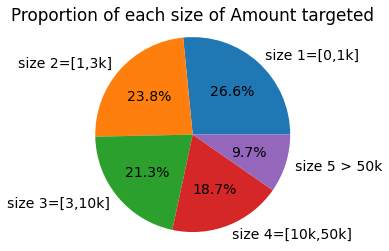

In [1311]:
fig1, ax1 = plt.subplots()
mpl.rcParams['font.size'] = 14.0
ax1.pie(df["size"].value_counts(),radius = 10, labels = ["size 1=[0,1k]", "size 2=[1,3k]", "size 3=[3,10k]" ,"size 4=[10k,50k]",'size 5 > 50k'], autopct='%1.1f%%', textprops=dict(color="black"))
plt.title("Proportion of each size of Amount targeted", color="black")
ax1.axis('equal')



Text(0.5, 1.0, 'Correlation matrix of the principal variables')

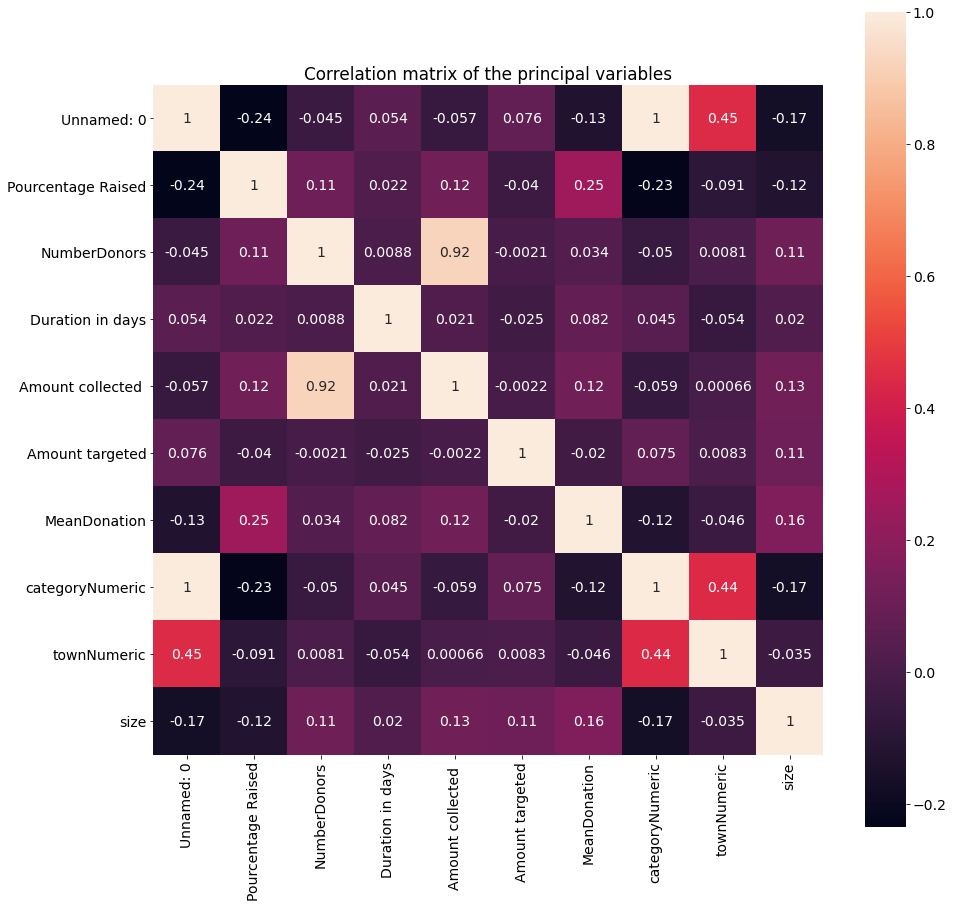

In [1312]:
import seaborn as sn

plt.figure(figsize=(15,15))
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True, square=True).set_title("Correlation matrix of the principal variables")


<b> We drop useless columns

In [1313]:
df.drop(['Unnamed: 0', 'title', 'collect','Description'], axis=1, inplace=True)


<b> We drop the 4th quartile for eacht category which contains the highest, and sometimes fake, values 

In [1314]:
df3=df.loc[df['Categorie']==catégorie[-1]]
df3=df3.loc[df3['Amount collected ']<df3['Amount collected '].describe()[6]]
for i in range(len(catégorie)-1,-1,-1):
    df2=df.loc[df['Categorie']==catégorie[i]]

    #drop 4th quartile of highest values
    df2=df2.loc[df2['Amount collected ']<df2['Amount collected '].describe()[6]]
    df3= pd.concat([df2,df3])
df=df3.reset_index(drop=True)


In [1315]:
df.to_csv('datacleaned.csv')

### III/ First Analysis

<b>III.1. First look 

In [1316]:
df.corr()

,Pourcentage Raised,NumberDonors,Duration in days,Amount collected,Amount targeted,MeanDonation,categoryNumeric,townNumeric,size
Pourcentage Raised,1.000000,0.521018,0.009332,0.453258,-0.029912,0.381932,-0.288252,-0.128987,-0.224936
NumberDonors,0.521018,1.000000,-0.045465,0.826306,-0.018850,0.283699,-0.275520,-0.091898,0.123799
Duration in days,0.009332,-0.045465,1.000000,-0.073642,-0.035111,-0.011334,0.060068,-0.063408,-0.036602
Amount collected,0.453258,0.826306,-0.073642,1.000000,-0.016136,0.516285,-0.258784,-0.070531,0.203864
Amount targeted,-0.029912,-0.018850,-0.035111,-0.016136,1.000000,-0.036941,0.072973,0.000023,0.116602
MeanDonation,0.381932,0.283699,-0.011334,0.516285,-0.036941,1.000000,-0.300698,-0.125947,0.151083
categoryNumeric,-0.288252,-0.275520,0.060068,-0.258784,0.072973,-0.300698,1.000000,0.455853,-0.128474
townNumeric,-0.128987,-0.091898,-0.063408,-0.070531,0.000023,-0.125947,0.455853,1.000000,-0.017333
size,-0.224936,0.123799,-0.036602,0.203864,0.116602,0.151083,-0.128474,-0.017333,1.000000


In [1317]:
for e in catégorie:
    print(e)
    print('\n')
    print(df.loc[df['Categorie']==e].describe())
    print('\n')


Medical, Illness & Healing


       Pourcentage Raised  NumberDonors  Duration in days  Amount collected   \
count           72.000000     72.000000         72.000000          72.000000   
mean            18.551389     14.361111         38.708333         491.458333   
std             24.022143     12.421365         26.346787         405.798289   
min              1.000000      1.000000          4.000000          10.000000   
25%              2.475000      6.000000         16.000000         192.500000   
50%              8.800000     11.500000         31.000000         366.500000   
75%             22.925000     19.000000         58.250000         719.000000   
max            100.000000     66.000000         93.000000        1545.000000   

       Amount targeted  MeanDonation  categoryNumeric  townNumeric       size  
count        72.000000     72.000000             72.0    72.000000  72.000000  
mean      10336.263889     40.684750              1.0    38.625000   2.888889  
std       

<b> III.2/Let's look at the collect of the last month, we will only work on DECEMBER

In [1318]:
mask_december = (df['Creation Date'] > '2022-1-1') & (df['Creation Date'] <= '2022-1-31')

mask_SmallCap = (df['Amount targeted']<5000)
mask_MidCap = (df['Amount targeted']>5000)& (df['Amount targeted']<50000)
mask_BigCap=(df['Amount targeted']>50000)

#Collects of december
december=df.loc[mask_december]


<b> III.3/ Relation Duration of the collect and Pourcentage Raised

Text(0, 0.5, 'Pourcentage raised')

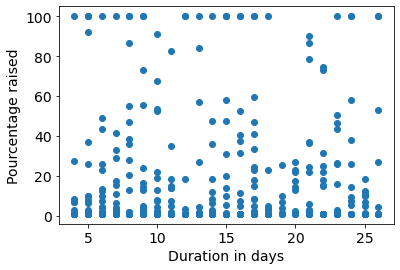

In [1319]:
#For all categories
plt.figure()
    
x=december['Duration in days']
y=december['Pourcentage Raised']
    
fig=plt.scatter(x, y )
plt.xlabel('Duration in days')
plt.ylabel('Pourcentage raised')


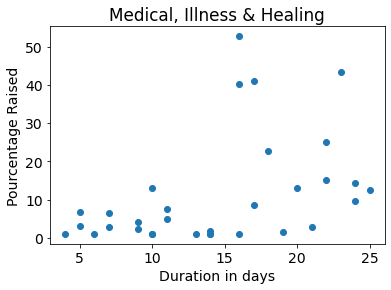

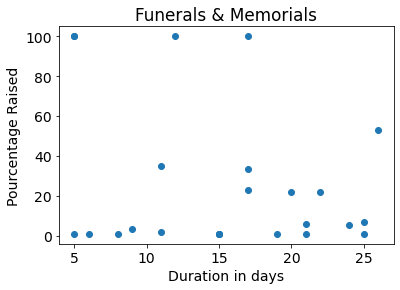

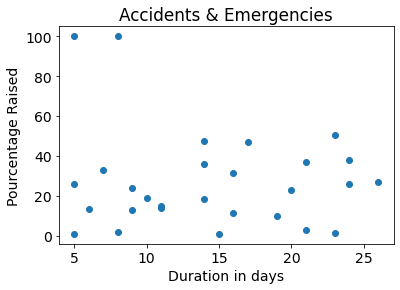

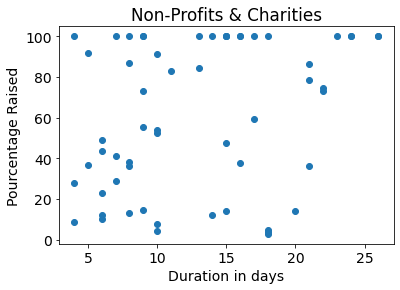

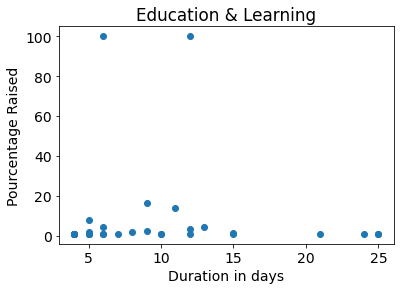

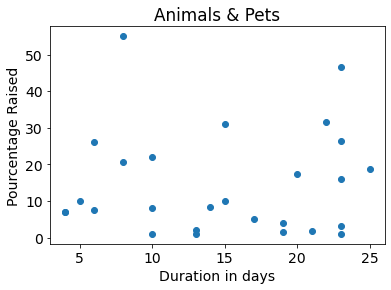

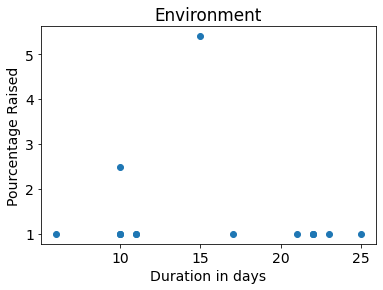

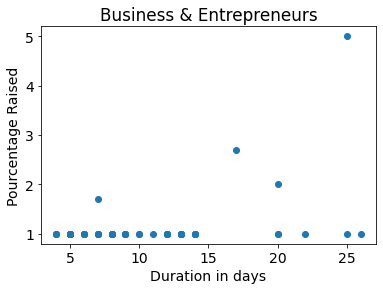

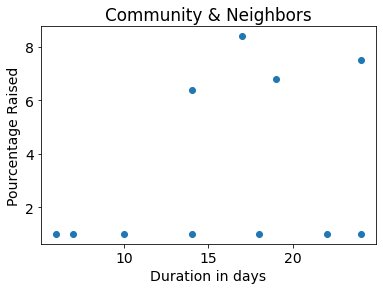

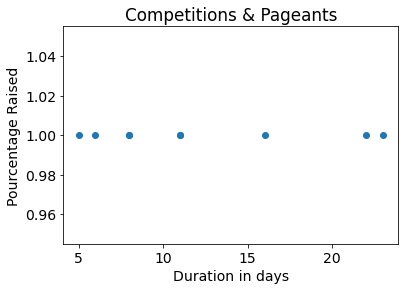

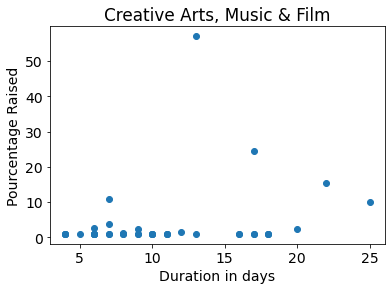

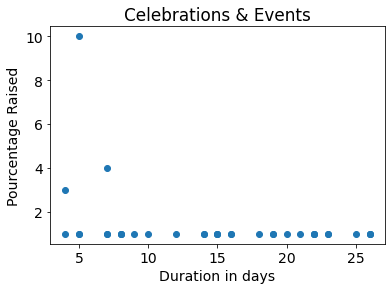

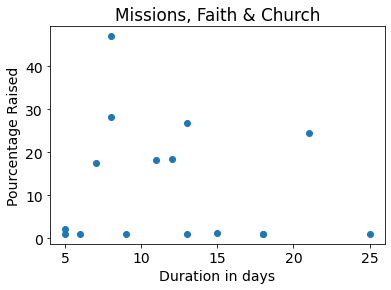

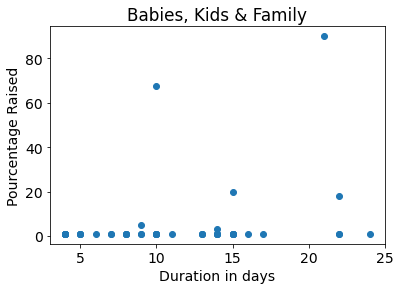

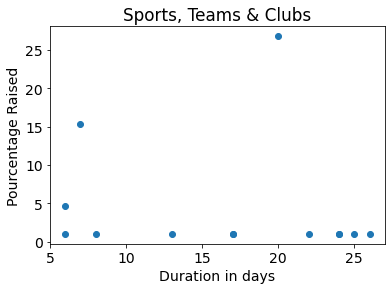

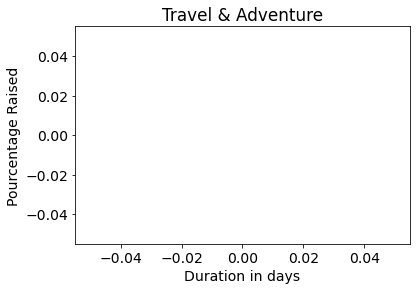

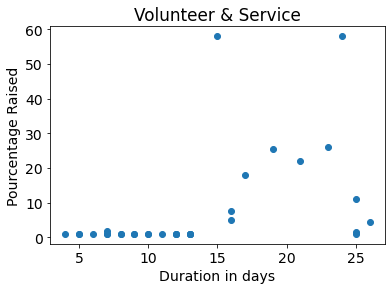

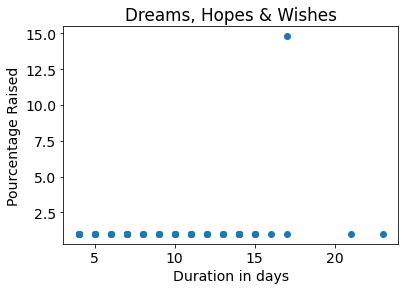

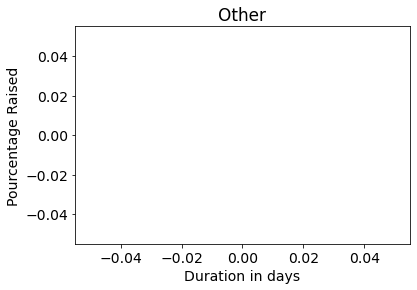

In [1320]:
#For each category
for cat in catégorie:
    plt.figure()
    
    x=december.loc[(df['Categorie'] ==cat)]['Duration in days']
    y=december.loc[(df['Categorie'] ==cat)]['Pourcentage Raised']
    
    fig=plt.scatter(x, y )
    plt.title(cat)
    plt.xlabel('Duration in days')
    plt.ylabel('Pourcentage Raised')

 =>No real model between Duration of the collect and Pourcentage Raised

<b> III.4/ Relation between descriptions of projects and Pourcentage Raised

<b> III.4.1/ We make a dictionnary of keywords for each category we will use to study descriptions

In [1341]:
#We look at the words with the biggest occurences for each category (open 'occurences' file )
from collections import Counter
txt=[]
for cat in catégorie:
    list1=[]
    for e in df.loc[(df['Categorie'] ==cat)]['Short_description']:
        list1=list1+e
    counts = Counter(list1)
    txt.append(cat)
    txt.append("      ")
    txt.append(counts)


with open('occurences.txt', 'w') as f:
    for item in txt:
        f.write("%s\n" % item)

In [ ]:
#We list the words of occurences that are keywords, which means the ones with a signification linked with the category

motsclés1=[[' douleur, association, funds, générosité, surgery, financier, remercie, disease, cancer, traitements, opération, besoin,enfant, mère '], 
[' family, obsèques, children, soutien, remercie, enterrement, hopital, association, community, maman '],
[' typhon, community, home, treatment, soutien, reconstruire, destroyed, maison, father, famille '],
[' support, community, together, children, foundation, students, animal, organization, cause, education, property, building '],
[' school, France, children, formation, yhèse, étude, construction, association, classe, famille '],
[' vétérinaire, opération, chien, frais, traitements, sauver, chimiothérapie, chat, examens, chevaux '],
[ ' association, environnement, société, développement, qualité, paris, climate, change, sensibiliser, scientifique, électricité »'],
[' agricole, communication, restaurant, investissement, agriculture, business, social, objectif, activité, professionnelle '],
[' vaccination, family, community, water, business, needs, health '],
[' compétition, championnat, international, opportunity, formation, passion, métrage, vidéo, réalisation, training ' ],
[ ' association, computer, vidéo, ordinateur, album, montage, formation, documentary ' ],
[ ' festival, conference, transpersonnalité, musique, climate, justice, agreement, anniversaire '],
[ ' mission, community, christ, church, évangélisation, voyage, prayer, christians, orphanages '],
[ ' famille, maison, besoin, place, cancer, association, logement, travaux, children ' ],
[ ' coach, tennis, equipments, soccer, Olympic, academy, club, basketball, soccer, volleyball, ironman ' ],
[ ' voyage, dream, equipment, découvrir, trail, aventure, vidéo, professionnelle, birthday ' ],
[ ' enfants, villages, typhon, association, education, maisons, acheter, christmas, nourrir ' ],
[ ' refugee, voyage, meditation, pédagogique, besoin, school, program '],
[]
          ]
motsclés=[]

for e in motsclés1:
    motsclés.append(word_tokenize(str(e).replace(',','').replace('[','').replace(']','').replace('"','').replace("'" ,'')))
    

In [ ]:
#We create a dictionnary linking a category and the keywords linked with it
motclé_dict=dict()
#catégorie is defined in II.8/
for i in range(len(catégorie)):
    motclé_dict[catégorie[i]]=motsclés[i]

In [ ]:
dict_category=dict()
#catégorie is defined in II.8/
for i in range(len(catégorie)):
    dict_category[i]=catégorie[i]

<b>III.4.2/ We give for each project a "scoreword": its the occurences of the keywords in its description

In [ ]:
#This function counts the occurences of the words of a list1 in another list2.
def countword(list1, list2):
    occu=dict()
    for word in list1:
        #print(word)
        occu[word]=list2.count(word)
    return occu



In [ ]:
#This function counts the numbers of matching words from the description (list1) with the keywords of the category(list2)
def scoreWord(index):
    sum=0
    count=countword(motclé_dict[df['Categorie'][index]],df['Short_description'][index])
    for e in count:
        sum+=count[e]
    return sum 


In [ ]:
#We create a column scoreword
scoreword=[]
for i in range(len(df['Short_description'])):
    scoreword.append(int(scoreWord(i)))
df['ScoreWord']=scoreword

<b>III.4.3/ Relation between ScoreWord and Pourcentage Raised

In [ ]:
december=df.loc[mask_december]

for cat in catégorie:
    plt.figure()

    x=december.loc[(december['Categorie'] ==cat)]['ScoreWord']
    y=december.loc[(december['Categorie'] ==cat)]['Pourcentage Raised']
    
    fig=plt.scatter(x, y )
    plt.title(cat)
    plt.xlabel('ScoreWord')
    plt.ylabel('Pourcentage Raised')

<b> Relation between Number of Donors and ScoreWord for each category

In [ ]:

december=df.loc[mask_december]

for cat in catégorie:
    plt.figure()

    x=december.loc[(december['Categorie'] ==cat)]['ScoreWord']
    y=december.loc[(december['Categorie'] ==cat)]['NumberDonors']
    
    fig=plt.scatter(x, y )
    plt.title(cat)
    plt.xlabel('ScoreWord')
    plt.ylabel('Number of donors')

<b> Relation between Duration in days and Number of donors for each category

In [ ]:
december=df.loc[mask_december]

for cat in catégorie:
    plt.figure()

    x=december.loc[(december['Categorie'] ==cat)]['Duration in days']
    y=december.loc[(december['Categorie'] ==cat)]['NumberDonors']
    
    fig=plt.scatter(x, y )
    plt.title(cat)
    plt.xlabel('ScoreWord')
    plt.ylabel('Number of donors')


<b> Relation between Number of Donors and Amount collected

In [ ]:
december=df.loc[mask_december]

for cat in catégorie:
    plt.figure()
 

    x=december.loc[(december['Categorie'] ==cat)]['NumberDonors']
    y=december.loc[(december['Categorie'] ==cat)]['Amount collected ']
    
    fig=plt.scatter(x, y )
    plt.title(cat)
    plt.xlabel('ScoreWord')
    plt.ylabel('Number of donors')


<b> Relation between Number of Donors and ScoreWord inside same size projects

In [ ]:
#SmallCap
decemberSmallCap=df.loc[mask_december&mask_SmallCap]
#print(decemberSmallCap.corr())
for cat in catégorie:
    plt.figure()
 

    x=decemberSmallCap.loc[(decemberSmallCap['Categorie'] ==cat)]['MeanDonation']
    y=decemberSmallCap.loc[(decemberSmallCap['Categorie'] ==cat)]['Pourcentage Raised']
    
    fig=plt.scatter(x, y )
    plt.title(cat)
    plt.xlabel('ScoreWord')
    plt.ylabel('Number of donors')


<b> Relation berwwen Pourcentage Raised and MeanDonation for each cap
    

In [ ]:
#SmallCap
decemberSmallCap=df.loc[mask_december&mask_SmallCap]
plt.figure()
 

x=decemberSmallCap['MeanDonation']
y=decemberSmallCap['Pourcentage Raised']
    
fig=plt.scatter(x, y )
plt.title(cat)
plt.xlabel('ScoreWord')
plt.ylabel('Number of donors')


decemberSmallCap.corr()


In [ ]:
#BigCap
decemberBigCap=df.loc[mask_december&mask_BigCap]
plt.figure()
 

x=decemberBigCap['MeanDonation']
y=decemberBigCap['Pourcentage Raised']
    
fig=plt.scatter(x, y )
plt.title('BigcAp')
plt.xlabel('Pourcentage Raised')
plt.ylabel('Meandonation')


decemberBigCap.corr()


In [ ]:
#SmallCap
decemberMidCap=df.loc[mask_december&mask_MidCap]
plt.figure()
 

x=decemberMidCap['MeanDonation']
y=decemberMidCap['Pourcentage Raised']
    
fig=plt.scatter(x, y )
plt.title('MidCAp')
plt.xlabel('Pourcentage Raised')
plt.ylabel('Meandonation')


decemberMidCap.corr()


<b> OLS regression because strong correlation betwen NumberDonors and Amount collected

In [ ]:
from sklearn import linear_model


X=decemberSmallCap[['NumberDonors']]
y=decemberSmallCap["Amount collected "]

model=linear_model.LinearRegression()
results=model.fit(X,y)

y_pred = model.predict(X)
plt.scatter(X,y)
plt.plot(X,y_pred,color='r')

print(results.score(X, y, sample_weight=None))

In [ ]:
from sklearn import linear_model


X=decemberMidCap[['NumberDonors']]
y=decemberMidCap["Amount collected "]

model=linear_model.LinearRegression()
results=model.fit(X,y)

y_pred = model.predict(X)
plt.scatter(X,y)
plt.plot(X,y_pred,color='r')

print(results.score(X, y, sample_weight=None))

In [ ]:
df.corr()

In [ ]:
def OLS_per_category(cat,covariates):
    df2=df.loc[df['Categorie']==cat]

    #drop 4th quartile of highest values
    df2=df2.loc[df2['Amount collected ']<df2['Amount collected '].describe()[6]]
    
    #Create columns "description contains or not the keyword"
    for keyword in motclé_dict[cat]:
        list=[]
        for collect_description in df2['Short_description']:
            if keyword in collect_description:
                list.append(1)
            else:
                list.append(0)
        df2[keyword]=list
    
    #Create columns categories:
    '''for cat2 in catégorie:
        list=[]
        for categ in df2['Categorie']:
            if categ==cat2:
                list.append(1)
            else:
                list.append(0)
        df2[cat2]=list'''
    
    plt.figure(figsize=(28,28))
    corrMatrix = df2.corr()
    sn.heatmap(corrMatrix, annot=True, square=True).set_title("Correlation matrix of the principal variables")
    #OLS
    X = df2[covariates]
    #X = df2[['ScoreWord','Duration in days']+(motclé_dict[cat])]

    Y=df2['Amount collected ']

    model = sm.OLS(Y, X)
    results = model.fit()
    print(results.summary())
    #print(results.params)
    
    
    fig, ax = plt.subplots()
    fig = sm.graphics.plot_fit(results, 0, ax=ax)
    ax.set_ylabel("Murder Rate")
    ax.set_xlabel("ScoreWord")
    ax.set_title("Amount collected")

In [ ]:
#motclé_dict[catégorie[1]]
OLS_per_category('Accidents & Emergencies',['Duration in days'])

In [ ]:
f
motclé_dict['Accidents & Emergencies']

In [ ]:
pd.options.display.max_columns = 500

In [ ]:
df3=df.loc[df['Categorie']==catégorie[-1]]
df3=df3.loc[df3['Amount collected ']<df3['Amount collected '].describe()[6]]
for i in range(len(catégorie)-1,-1,-1):
    df2=df.loc[df['Categorie']==catégorie[i]]

    #drop 4th quartile of highest values
    df2=df2.loc[df2['Amount collected ']<df2['Amount collected '].describe()[6]]
    df3= pd.concat([df2,df3])
df = df3
df